## A/B эксперимент по рекомендации постов пользователям.
#### Научил сервис разбивать пользователей на группы и для каждой из групп использовать одну из двух реализованных моделей (послабее модель control и более сильную test) для проведения A/B эксперимента. 
#### Эксперимент проводился на пользователях в течение 2 недель. В результаты мы получили сырые данные об эксперименте, которые обработали, и сделали вывод об эффективности модели test. 

In [267]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import binomtest
from scipy.stats import mannwhitneyu, ttest_ind
import hashlib

In [2]:
# Загружаем даныне
likes = pd.read_csv('likes.csv') # Данные о лайках
views = pd.read_csv('views.csv') # Ответы нашего сервиса с рекомендациями. 


In [3]:
views['date'] = pd.to_datetime(views.timestamp, unit='s')
likes['date'] = pd.to_datetime(likes.timestamp, unit='s')

In [4]:
views.head(3)

,user_id,exp_group,recommendations,timestamp,date
0,128381,control,[3644 4529 4704 5294 4808],1654030803,2022-05-31 21:00:03
1,146885,test,[1399 1076 797 7015 5942],1654030811,2022-05-31 21:00:11
2,50948,test,[2315 3037 1861 6567 4093],1654030825,2022-05-31 21:00:25


In [5]:
likes.head(3)

,user_id,post_id,timestamp,date
0,128381,4704,1654030804,2022-05-31 21:00:04
1,146885,1399,1654030816,2022-05-31 21:00:16
2,50948,2315,1654030828,2022-05-31 21:00:28


#### Проверяем , нет ли у нас пользователей, которые попали в обе группы.

In [6]:
test_group_ids = views[views['exp_group'] == 'test']['user_id'].tolist()
control_group_ids = views[views['exp_group'] == 'control']['user_id'].tolist()

In [7]:
test_group_ids  = set(test_group_ids)
control_group_ids = set(control_group_ids)

Пользователи которые по ошибки попали в группу test и control одновременно

In [8]:
test_group_ids.intersection(control_group_ids)

{25623, 55788, 142283, 148670}

Удалим из наших таблиц таких пользователей. 

In [9]:
views = views[~views.user_id.isin(test_group_ids.intersection(control_group_ids))]
likes = likes[~likes.user_id.isin(test_group_ids.intersection(control_group_ids))]

Проверяем, что группы получаются одинакового размера по пользователям

In [10]:
views['exp_group'].value_counts()

test       96898
control    96370
Name: exp_group, dtype: int64

In [11]:
views.groupby('user_id').first().exp_group.value_counts()

test       32659
control    32350
Name: exp_group, dtype: int64

Есть немного пользователей сразу в 2 группах, группы почти равного размера. Применим критерий для долей (биномиальный тест), чтобы проверить соответствие этой доли ожидаемым 0.5.

In [12]:
N_test  = views.groupby('user_id').first().exp_group.value_counts().test
N = views.groupby('user_id').first().exp_group.count()
print(f"95-процентный доверительный интервал доли группы {proportion_confint(N_test, N, alpha=0.05, method='normal')}")
binomtest(k=N_test, n=N, p=0.5) 

95-процентный доверительный интервал доли группы (0.49853309789386646, 0.5062200901262539)


BinomTestResult(k=32659, n=65009, alternative='two-sided', proportion_estimate=0.5023765940100602, pvalue=0.2270501563614752)

##### Таким образом,  P-value равно 0.2271. Это означает, что если нулевая гипотеза верна (доля равна 0.5), то вероятность получить такое или еще более экстремальное различие составляет примерно 0.2271, что не является статистически значимым на уровне значимости 0.05. На основании полученного p-value, нет достаточных доказательств, чтобы отвергнуть нулевую гипотезу о равенстве долей.

#### Соберем таблицу, в которой будут пользователи, попавшие в наш эксперимент (то есть те, для которых мы строили хотя бы одну рекомендацию). Посчитаем, кто из них сколько лайков сделал.

In [13]:
# Группируем по 'user_id' и считаем количество значений в колонке 'post_id'
grouped_likes = likes.groupby('user_id').post_id.count()

# Преобразуем Series в DataFrame,переименовав колонки
users_likes = grouped_likes.reset_index().rename(columns={'post_id': 'sum_likes'})

users_likes

,user_id,sum_likes
0,200,1
1,201,3
2,202,2
3,212,4
4,213,7
...,...,...
58162,168525,2
58163,168532,4
58164,168538,5
58165,168541,2


In [14]:
views_ = views.groupby('user_id').first()

In [15]:
df = pd.merge(views_, users_likes, on='user_id', how='left') #объединим таблицы left- join,  при котором останутся все пользователи с просмотрами (даже те, у кого нет лайков)

In [16]:
df[df['sum_likes'].isna()]

,user_id,exp_group,recommendations,timestamp,date,sum_likes
8,227,test,[3006 4945 909 1255 6630],1655080360,2022-06-13 00:32:40,NaN
18,251,test,[6284 6702 1611 2229 6288],1654107877,2022-06-01 18:24:37,NaN
22,261,test,[1546 4161 1523 1220 1900],1655215428,2022-06-14 14:03:48,NaN
27,279,test,[3881 2547 940 1774 2287],1654093645,2022-06-01 14:27:25,NaN
37,299,test,[2678 3668 1394 6175 6706],1654803833,2022-06-09 19:43:53,NaN
...,...,...,...,...,...,...
64985,168490,control,[1576 5277 4161 799 563],1654199500,2022-06-02 19:51:40,NaN
64999,168519,control,[1983 7263 4304 4422 4009],1654557156,2022-06-06 23:12:36,NaN
65002,168526,control,[5225 1536 6745 338 520],1654193016,2022-06-02 18:03:36,NaN
65006,168544,test,[7096 6288 1482 2743 2575],1654268018,2022-06-03 14:53:38,NaN


6842 юзеров не сделали ни одного лайка, заполним эти значения нулями

In [17]:
df['sum_likes'] = df['sum_likes'].fillna(0)

Посчитаем пропорцию тех, у кого есть лайки, относительно всех пользователей

In [18]:

# Расчитываем долю пользователей с лайками 
(df['sum_likes'] > 0).mean()


0.8947530341952653

In [19]:
# Расчитываем долю пользователей с лайками и среднее число лайков в каждой группе
df_like = df.groupby('exp_group').agg(share_like=('sum_likes', lambda x: (x > 0).mean()),
                                      mean_likes=('sum_likes', 'mean'))
df_like

,share_like,mean_likes
exp_group,,
control,0.891314,3.487079
test,0.898160,3.592578


Как видим в группе test кол-во и среднее лайков выросло.

### Оценим, различаются ли число лайков между группами.

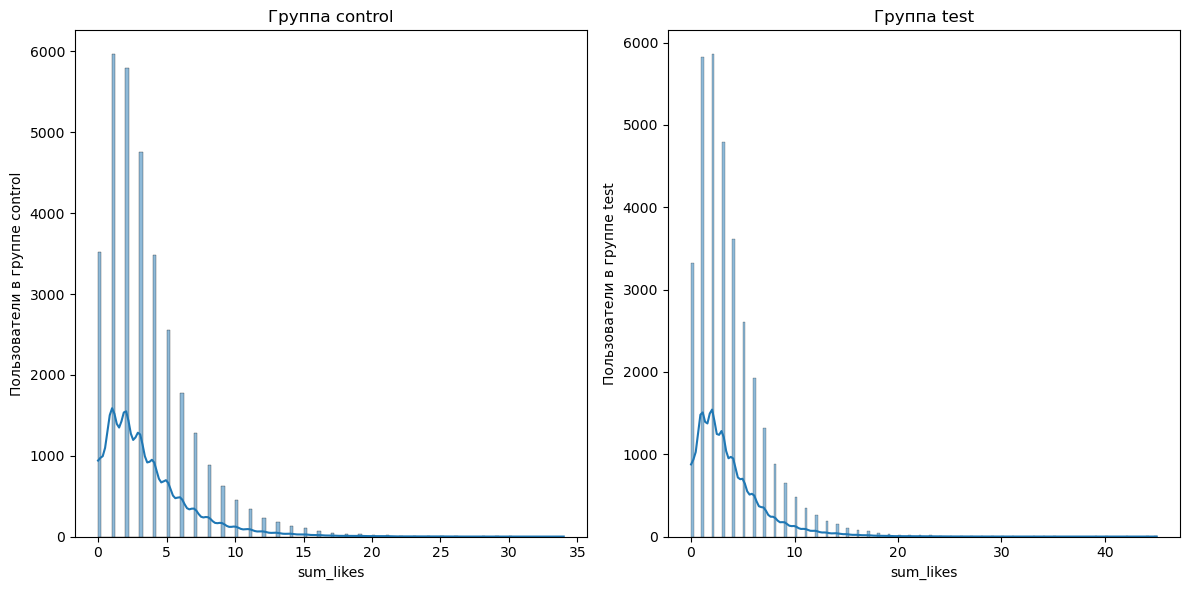

In [20]:
# Создаем сетку из двух графиков рядом
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# График для группы 'control'
control = sns.histplot(df[df['exp_group'] == 'control'].sum_likes, kde=True, ax=ax1)
control.set(ylabel='Пользователи в группе control')
ax1.set_title('Группа control')

# График для группы 'test'
test = sns.histplot(df[df['exp_group'] == 'test'].sum_likes, kde=True, ax=ax2)
test.set(ylabel='Пользователи в группе test')
ax2.set_title('Группа test')

plt.tight_layout()
plt.show()

Кол-во лайков имеет логнормальное распределение. Поэтому применим непараметрический критерии Манна-Уитни-Уилкоксона.

In [21]:
# Фильтруем DataFrame по группе 'control'
contr = df.loc[df.exp_group == 'control', 'sum_likes']

# Фильтруем DataFrame по группе 'test'
test = df.loc[df.exp_group == 'test', 'sum_likes']

# Выполняем тест Манна-Уитни-Уилкоксона
statistic, pvalue = mannwhitneyu(contr, test)

print(f"Статистика U: {statistic}")
print(f"P-value: {pvalue}")

Статистика U: 518358073.0
P-value: 2.9585062792441964e-05


Значение статистики U представляет собой сумму рангов, присвоенных выборкам во время теста. Чем больше значение U, тем больше различий между выборками.

P-value (вероятность) равное 2.9585062792441964e-05 означает, что если нулевая гипотеза верна (отсутствие различий между группами), то вероятность получить такое или еще более экстремальное различие составляет 2.9585062792441964e-05, то есть очень маленькая.

Исходя из этого, мы можем сделать вывод о статистической значимости различий между группами. В данном случае, маленькое значение p-value говорит о том, что у нас есть статистически значимые различия между группами 'control' и 'test' в отношении количества лайков.

##### Таким образом, мы можем отвергнуть нулевую гипотезу о равенстве распределений, существует статистически значимое различие в количестве лайков между группами control и test.

### Подсчёт метрики Hitrate@5  
#### доля рекомендаций, в которые пользователи кликнули

In [239]:
merged_df = views.merge(likes, on='user_id', how='left')

In [240]:
merged_df['recommendations'] = merged_df.recommendations.apply(
    lambda x: list(map(int, filter(bool, x[1:-1].split(' '))))
) # добавим разделить в столбец с recommendations

In [259]:
merged_df.head(2)

,user_id,exp_group,recommendations,timestamp_x,date_x,post_id,timestamp_y,date_y
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,2022-05-31 21:00:03,4704.0,1.654031e+09,2022-05-31 21:00:04
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,2022-05-31 21:00:03,5294.0,1.654031e+09,2022-05-31 21:00:38


In [253]:
merged_df.shape

(1016889, 8)

##### Помечаем все ненужные нам посты. Это те, у которых нет id (стоит пропуск в post_id), которые лайкнули позже, чем через час, в которых просмотр оказался позже лайка, а также те, которые не рекомендовали

In [248]:


def update_post_id(row):
    # Преобразование значений временных меток в формат pd.Timestamp
    timestamp_x = pd.Timestamp(row.timestamp_x)
    timestamp_y = pd.Timestamp(row.timestamp_y)
    
    if (
        row.post_id == -1  # Если post_id равно -1
        or timestamp_x > timestamp_y  # Если timestamp_x больше timestamp_y
        or timestamp_x + pd.Timedelta(hours=1) < timestamp_y  # Если между timestamp_x и timestamp_y прошло более 1 часа
        or row.post_id not in row.recommendations  # Если post_id не находится в списке рекомендаций
    ):
        return -1  # Возвращаем -1
    else:
        return row.post_id  # Возвращаем исходное значение post_id

# Применяем функцию update_post_id к каждой строке датафрейма
merged_df['post_id'] = merged_df.apply(update_post_id, axis=1)


#### Для каждого юзера/поста/просмотра подбираем количество лайков, связанное именно с этой комбинацией. То есть лайкнул человек этот пост после показа или нет, 1 или 0, True или False. Вот это и будет наш hitrate'

In [258]:
# Функция для агрегации значений столбца 'post_id'
def my_agg(values):
    values = set(values)  # Преобразование значений во множество для уникальности
    if -1 in values and len(values) >= 2:  # Если есть значение -1 и количество уникальных значений >= 2
        return 1  
    elif -1 not in values:  
        return 1  
    return 0  

tmp_agg = merged_df.groupby(['user_id', 'exp_group', 'timestamp_x'])['post_id'].agg(my_agg)
print(f"Итоговое значение метрики Hitrate@5:{tmp_agg.reset_index().post_id.mean()}")

Итоговое значение метрики Hitrate@5:0.7137549930666225


### Оценка различий между группами и применение бакетного подхода.
##### Для оценки различий между группами в нашем случае, мы не можем использовать z-критерий для долей, так как каждый пользователь может встречаться несколько раз в выборке. Вместо этого мы будем применять бакетный подход, который позволит нам оценить значимость различий, используя групповой hitrate (или CTR) - долю успешных действий в каждом бакете.

##### Для этого мы разделим данные на 100 бакетов и вычислим hitrate для каждого бакета. Затем мы сможем сравнить hitrate между группами и оценить статистическую значимость различий. Уровень значимости останется на прежнем уровне 0.05.

##### Таким образом, мы сможем определить, есть ли статистически значимые различия в hitrate между группами, используя бакетный подход.

In [260]:
tmp_agg = tmp_agg.reset_index().rename(columns={'post_id': 'hitrate'})

In [262]:
tmp_agg['bucket'] = tmp_agg['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + "your_salt_value").encode()).hexdigest(), 16) % 100
) # Присваиваем каждому пользователю случайный бакет, используя хэш-функцию MD5

In [263]:
tmp_agg['view'] = 1

#Группируем данные по 'exp_group' и 'bucket', суммируя значения 'hitrate' и 'view'
new_df = tmp_agg.groupby(['exp_group', 'bucket']).sum(['hitrate', 'view']).reset_index()
new_df['hitrate_bucket'] = new_df.hitrate / new_df.view 

new_df.head()

,exp_group,bucket,user_id,timestamp_x,hitrate,view,hitrate_bucket
0,control,0,92017399,1851532396728,793,1119,0.708668
1,control,1,81640987,1542106366406,653,932,0.700644
2,control,2,83711146,1689393886206,726,1021,0.711068
3,control,3,83356449,1634773739233,681,988,0.689271
4,control,4,75892301,1512322707824,654,914,0.715536


In [264]:
tmp_agg.groupby('exp_group').hitrate.mean()

exp_group
control    0.707108
test       0.720366
Name: hitrate, dtype: float64

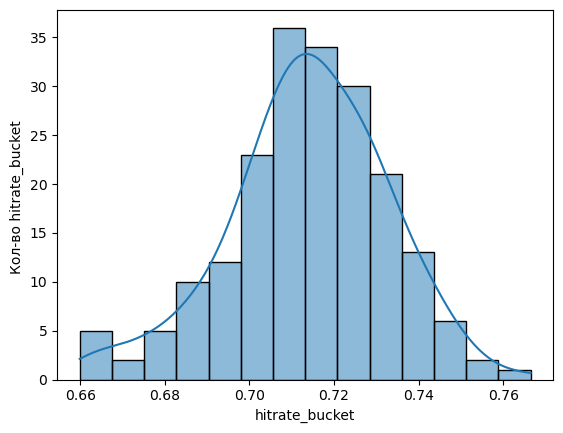

In [272]:
p = sns.histplot(new_df['hitrate_bucket'], kde=True)
p.set(ylabel = 'Кол-во hitrate_bucket ')
plt.show()

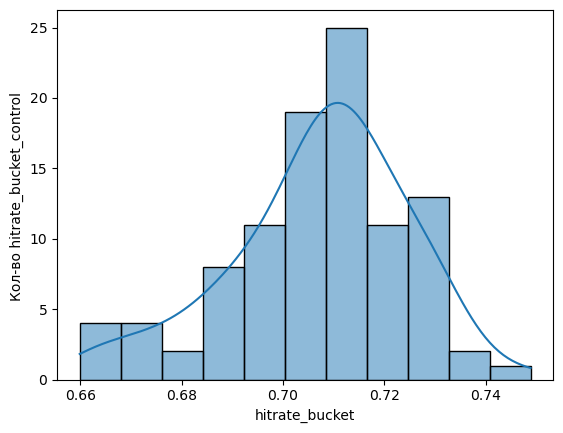

In [275]:
p = sns.histplot( new_df[new_df.exp_group == 'control'].hitrate_bucket, kde=True)
p.set(ylabel = 'Кол-во hitrate_bucket_control ')
plt.show()

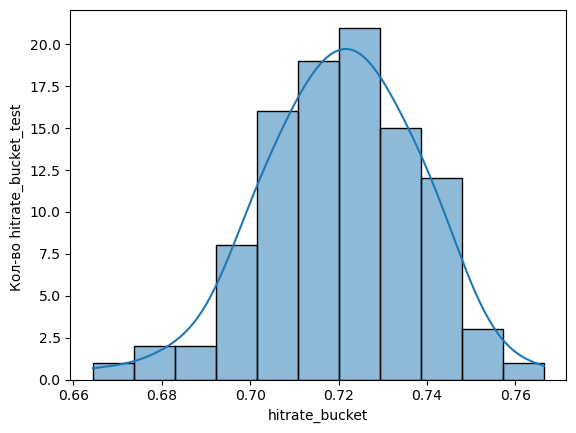

In [276]:
p = sns.histplot(new_df[new_df.exp_group == 'test'].hitrate_bucket, kde=True)
p.set(ylabel = 'Кол-во hitrate_bucket_test')
plt.show()

In [265]:
mannwhitneyu(
    new_df[new_df.exp_group == 'control'].hitrate_bucket,
    new_df[new_df.exp_group == 'test'].hitrate_bucket,
)

MannwhitneyuResult(statistic=2961.0, pvalue=6.330494742920094e-07)

In [268]:
ttest_ind(
    new_df[new_df.exp_group == 'control'].hitrate_bucket,
    new_df[new_df.exp_group == 'test'].hitrate_bucket,
)

Ttest_indResult(statistic=-5.337012548982593, pvalue=2.573350247286912e-07)

### Выводы
#### На основе анализа различий между группами 'control' и 'test' по показателю hitrate (доля успешных рекомендаций), мы пришли к следующим выводам:

#### Метод бакетирования был применен для оценки группового hitrate (CTR) с использованием 100 бакетов.

Далее, мы провели статистические тесты для проверки различий между группами 'control' и 'test':

>*Тест Манна-Уитни (mannwhitneyu) показал статистически значимое отклонение между hitrate_bucket в группе 'control' и группе 'test' (statistic=2961.0, __pvalue=6.330494742920094e-07__).*

>*Тест Стьюдента (ttest_ind) также показал статистически значимое отклонение между hitrate_bucket в группе 'control' и группе 'test' (statistic=-5.337012548982593, __pvalue=2.573350247286912e-07__).*

#### Исходя из результатов тестов, мы можем сделать вывод, что рекомендательная система в группе 'test' показывает лучшие результаты по сравнению с группой 'control'. Таким образом, мы можем рекомендовать использование рекомендательной системы группы 'test' как более эффективной.
